# 三组GLM实验
1、普通人对道德判断问题和法律判断问题的差别——配对t检验

2、法律职业人对道德判断问题和法律判断问题的差别——配对t检验

3、法律教育是否会改变人对于道德问题与法律问题的判断（两因子间的交互作用）——混合方差分析
# MVPA实验
四分类问题

# <center>以下内容仅包括GLM实验</center>
# 顺序：单个被试分析过程→一次性处理所有被试的FirstLevel→组分析（分别对应以上三组GLM实验）

### 数据概要：
* 25名普通人（001-025）
* 23名法律职业人（其他）
### 两因素混合设计2×3
* Between-Subjects Factors(2)：未接受过法律教育 & 接受过法律教育
* Within-Subjects Factors(3)：常识问题 & 法律问题 & 道德问题

# <center>单个被试分析过程</center>

In [24]:
%matplotlib inline
import sys
sys.path.append('/home/hcp/anaconda3/envs/xj/lib/python3.8/site-packages')
import os
import numpy as np
import pandas as pd
from glob import glob
from bids import BIDSLayout
import matplotlib.pyplot as plt
from nilearn.image import mean_img
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import make_glm_report, get_clusters_table
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain, plot_design_matrix, plot_contrast_matrix

In [25]:
data_dir = '/media/hcp/sdb1/bids'
layout = BIDSLayout(data_dir, derivatives=True)
tr = layout.get_tr(derivatives=True)

outdir = 'results_demo'
if not os.path.exists(outdir):
    os.mkdir(outdir)

conditions = ['common_sense', 'judge', 'moral']

### 定义一阶模型
其中drift_model参数的设置，会被最终添加到设计矩阵中（<font color="red">详情后述</font>）

In [26]:
fmri_glm = FirstLevelModel(t_r=tr,
                           noise_model='ar1',
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=1./160,
                           signal_scaling=False,
                           minimize_memory=False)

### 功能像文件

In [27]:
fmri_file = layout.get(subject='001', task='judgment', scope='derivatives', suffix='bold', extension='nii.gz', return_type='file')[0]
fmri_file

'/media/hcp/sdb1/bids/derivatives/fmriprep/sub-001/func/sub-001_task-judgment_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

### events.tsv文件

In [28]:
event_file = layout.get(subject='001', suffix='events')[0].path
events = pd.read_table(event_file)
events

,onset,duration,trial_type
0,3.000,14.280,moral
1,20.317,4.923,common_sense
2,28.291,14.309,judge
3,45.624,2.272,moral
4,50.929,2.871,common_sense
5,56.835,22.821,judge
6,82.676,3.140,moral
7,88.848,8.855,common_sense
8,100.726,15.001,judge
9,118.760,8.599,moral


### 6个头动参数作为混淆变量

In [29]:
confounds_file = layout.get(subject='001', scope='derivatives', extension='.tsv')[0].path
confounds = pd.read_table(confounds_file)
confounds_glm = confounds[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']].replace(np.nan, 0)
confounds_glm

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,0.016958,0.010309,0.021031,0.001090,0.000142,0.001110
1,0.018503,0.019711,0.020397,0.000670,0.000405,0.000813
2,0.021034,0.032520,0.025138,0.000670,0.000116,0.000931
3,0.016275,0.016612,0.002849,0.000670,0.000073,0.001044
4,-0.000037,0.004612,0.007679,0.000670,-0.000000,0.000509
...,...,...,...,...,...,...
159,-0.051812,-0.067833,-0.092168,0.002724,-0.000172,-0.000200
160,-0.040914,-0.057203,-0.057603,0.001865,0.000176,-0.000047
161,-0.051851,-0.091024,-0.063803,0.001603,0.000365,-0.000334
162,-0.047442,-0.068000,-0.057601,0.001475,0.000412,-0.000200


### 传入3个参数：功能像文件、events文件、混淆变量

In [30]:
fmri_glm = fmri_glm.fit(fmri_file, events, confounds_glm)

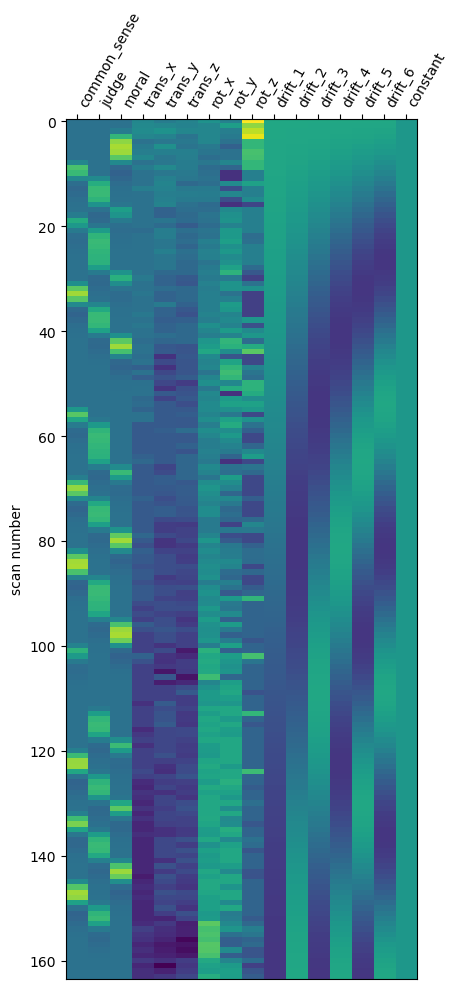

In [31]:
design_matrix = fmri_glm.design_matrices_[0]
plot_design_matrix(design_matrix)
plt.show()

# ↑混淆变量的选择：
### 由上可见，定义FirstLevelModel时选择的drift_model被添加到了设计矩阵中。

### 此外，某些教程或文献还建议将一阶导数，二阶导数，spike，poly等参数作为混淆变量添加进设计矩阵。

### 目前思路：从原理出发，哪些变量的加入可以最小化残差$\varepsilon$，就选用哪些变量。
真实值$Y=bX$

估计值$\hat{Y}=bX$

$\varepsilon=Y-\hat{Y}$

*********************

## 以judge为例，计算其统计量z分数（z_score为函数compute_contrast的默认类型）

源代码计算过程（顺序，以t值为例）：

* 由最小二乘法，得beta值
* 根据t分布（自由度）得P值
* 将P值转换为标准正态分布下的**z值**

计算t值时是用分子除以分母，其中分子为beta值-0，分母为标准差，但该标准差的计算方式没看懂

In [32]:
z_map = fmri_glm.compute_contrast("judge", output_type='z_score')

/home/hcp/anaconda3/envs/xj/lib/python3.8/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


### 此处显著性水平选为0.001，其对应的z值为3.090……，因此展示时threshold选为3.0

In [33]:
from scipy.stats import norm
z_threshold = norm.isf(0.001)
z_threshold

3.090232306167813

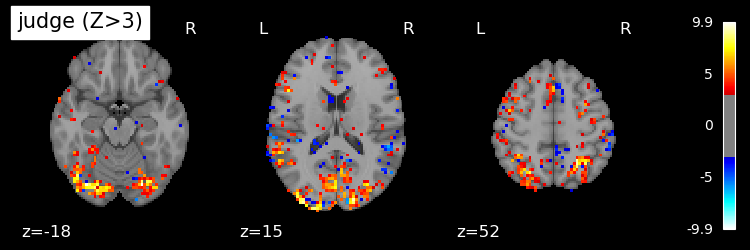

In [34]:
plot_stat_map(z_map, threshold=3.0, display_mode='z', cut_coords=3, black_bg=True,
              title='judge (Z>3)')
plt.show()

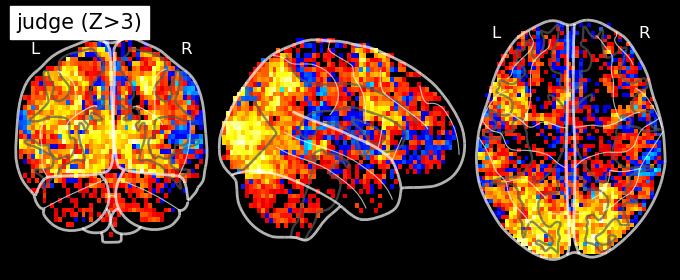

In [35]:
plot_glass_brain(z_map, threshold=3.0, black_bg=True, plot_abs=False,
                 title='judge (Z>3)')
plt.show()

### 保存z_map

In [36]:
z_map.to_filename(os.path.join(outdir, 'sub-%s-%s_zmap.nii.gz' % ('001', 'judge')))

# <center>一次性处理所有被试的FirstLevel</center>

In [37]:
import os
import numpy as np
import pandas as pd
from glob import glob
from bids import BIDSLayout
import matplotlib.pyplot as plt
from nilearn.image import mean_img
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import make_glm_report, get_clusters_table
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain, plot_design_matrix, plot_contrast_matrix

data_dir = '/media/hcp/sdb1/bids'
layout = BIDSLayout(data_dir, derivatives=True)
tr = layout.get_tr(derivatives=True)

outdir = 'results'
if not os.path.exists(outdir):
    os.mkdir(outdir)


fmri_glm = FirstLevelModel(t_r=tr,
                           noise_model='ar1',
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=1./160,
                           signal_scaling=False,
                           minimize_memory=False,
                           n_jobs=4)

conditions = ['common_sense', 'judge', 'moral']
temp = glob(os.path.join(data_dir,'sub-*'))
subs = sorted([i.split('\\')[-1][-3:] for i in temp])
#subs = ['001', '002', '003', '004', '005', '049', '050', '051', '052', '053']
print(subs)

for sub in subs:
    fmri_file = layout.get(subject=sub, task='judgment', scope='derivatives', suffix='bold', extension='nii.gz', return_type='file')[0]

    event_file = layout.get(subject=sub, suffix='events')[0].path
    events = pd.read_table(event_file)

    confounds_file = layout.get(subject=sub, scope='derivatives', extension='.tsv')[0].path
    confounds = pd.read_table(confounds_file)
    confounds_glm = confounds[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']].replace(np.nan, 0)

    fmri_glm = fmri_glm.fit(fmri_file, events, confounds_glm)

    for con in conditions:
        z_map = fmri_glm.compute_contrast(con, output_type='z_score')
        z_map.to_filename(os.path.join(outdir, 'sub-%s-%s_zmap.nii.gz' % (sub, con)))
    print(sub)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053']


/home/hcp/anaconda3/envs/xj/lib/python3.8/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


001
002
003
004
005
006


/home/hcp/anaconda3/envs/xj/lib/python3.8/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


007
008
009
010
011
012
013


/home/hcp/anaconda3/envs/xj/lib/python3.8/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


014
015
016
017
018
019
020
021
022
023
024
025
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052


/home/hcp/anaconda3/envs/xj/lib/python3.8/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


053


# <center>组分析过程</center>

In [38]:
import os
import numpy as np
import pandas as pd
from glob import glob
from bids import BIDSLayout
from nilearn import plotting
import matplotlib.pyplot as plt
from nilearn.image import mean_img
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import make_glm_report, get_clusters_table
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain, plot_design_matrix, plot_contrast_matrix

data_dir = '/media/hcp/sdb1/bids'
temp = glob(os.path.join(data_dir,'sub-*'))
subs = sorted([i.split('\\')[-1][-3:] for i in temp])
subs

['001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053']

# <center>目录</center>
# 1 普通人对道德判断问题和法律判断问题的差别——配对t检验
## ——1.1输入数据
## ——1.2设计矩阵
## ——1.3二阶模型
## ——1.4计算统计量z分数
## ——1.5三种多重比较校正 & 打印坐标点
# 2 法律职业人对道德判断问题和法律判断问题的差别——配对t检验
## ——2.1输入数据
## ——2.2设计矩阵
## ——2.3二阶模型
## ——2.4计算统计量z分数
## ——2.5三种多重比较校正 & 打印坐标点
# 3 法律教育是否会改变人对于道德问题与法律问题的判断——混合方差分析
## ——3.1输入数据
## ——3.2设计矩阵
## ——3.3二阶模型
## ——<font color="red">3.4对比矩阵</font>
## ——3.5计算统计量z分数
## ——3.6三种多重比较校正 & 打印坐标点

**********

# <center>1 普通人对道德判断问题和法律判断问题的差别——配对t检验</center>

### 1.1输入数据

In [56]:
outdir = 'results'
n_subjects_laypersons = 25 # TODO：普通人共有25名
moral_z_maps_laypersons = sorted(glob(os.path.join(outdir, '*moral_zmap.nii.gz')))[:n_subjects_laypersons]
judge_z_maps_laypersons = sorted(glob(os.path.join(outdir, '*judge_zmap.nii.gz')))[:n_subjects_laypersons]
print(len(moral_z_maps_laypersons))
print(len(judge_z_maps_laypersons))
second_level_input_laypersons = moral_z_maps_laypersons + judge_z_maps_laypersons
second_level_input_laypersons

25
25


['results/sub-001-moral_zmap.nii.gz',
 'results/sub-002-moral_zmap.nii.gz',
 'results/sub-003-moral_zmap.nii.gz',
 'results/sub-004-moral_zmap.nii.gz',
 'results/sub-005-moral_zmap.nii.gz',
 'results/sub-006-moral_zmap.nii.gz',
 'results/sub-007-moral_zmap.nii.gz',
 'results/sub-008-moral_zmap.nii.gz',
 'results/sub-009-moral_zmap.nii.gz',
 'results/sub-010-moral_zmap.nii.gz',
 'results/sub-011-moral_zmap.nii.gz',
 'results/sub-012-moral_zmap.nii.gz',
 'results/sub-013-moral_zmap.nii.gz',
 'results/sub-014-moral_zmap.nii.gz',
 'results/sub-015-moral_zmap.nii.gz',
 'results/sub-016-moral_zmap.nii.gz',
 'results/sub-017-moral_zmap.nii.gz',
 'results/sub-018-moral_zmap.nii.gz',
 'results/sub-019-moral_zmap.nii.gz',
 'results/sub-020-moral_zmap.nii.gz',
 'results/sub-021-moral_zmap.nii.gz',
 'results/sub-022-moral_zmap.nii.gz',
 'results/sub-023-moral_zmap.nii.gz',
 'results/sub-024-moral_zmap.nii.gz',
 'results/sub-025-moral_zmap.nii.gz',
 'results/sub-001-judge_zmap.nii.gz',
 'results/su

### 1.2设计矩阵

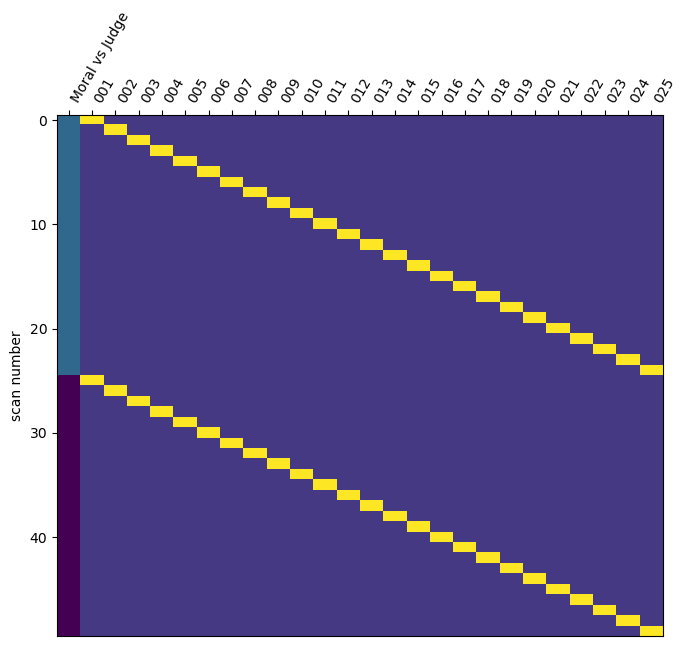

,Moral vs Judge,001,002,003,004,005,006,007,008,009,...,016,017,018,019,020,021,022,023,024,025
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
subject_effect_laypersons = np.vstack((np.eye(n_subjects_laypersons), np.eye(n_subjects_laypersons)))
condition_effect_laypersons = np.hstack(([1] * n_subjects_laypersons, [-1] * n_subjects_laypersons))

paired_design_matrix_laypersons = pd.DataFrame(
    np.hstack((condition_effect_laypersons[:, np.newaxis], subject_effect_laypersons)),
    columns=["Moral vs Judge"] + subs[:n_subjects_laypersons],
)
plot_design_matrix(paired_design_matrix_laypersons)
plt.show()
paired_design_matrix_laypersons

### 1.3二阶模型

In [43]:
second_level_model_paired_laypersons = SecondLevelModel(n_jobs=4).fit(
    second_level_input_laypersons, design_matrix=paired_design_matrix_laypersons
)

### 1.4计算统计量——无需指定对比矩阵，仅需指定单个参数

In [44]:
z_maps_paired_laypersons = second_level_model_paired_laypersons.compute_contrast("Moral vs Judge", output_type="z_score")

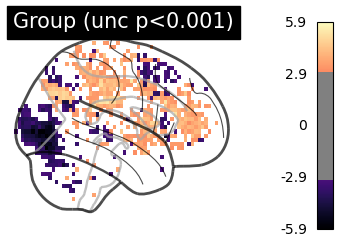

The unc threshold is 3.09


In [45]:
from scipy.stats import norm
p001_unc = norm.isf(0.001)

plotting.plot_glass_brain(z_maps_paired_laypersons, colorbar=True, threshold=p001_unc,
                          title='Group (unc p<0.001)',
                          plot_abs=False, display_mode='x', cmap='magma')
plotting.show()
print(f"The unc threshold is {p001_unc:.3g}")

### 1.5三种多重比较校正 & 打印坐标点

In [46]:
thresholded_map1_laypersons, threshold1_laypersons = threshold_stats_img(
    z_maps_paired_laypersons, alpha=0.001, height_control="fpr", cluster_threshold=0,
    two_sided=True,
)
print(f"The FPR<.001, clusters>10 voxels threshold is {threshold1_laypersons:.3g}")

The FPR<.001, clusters>10 voxels threshold is 3.29


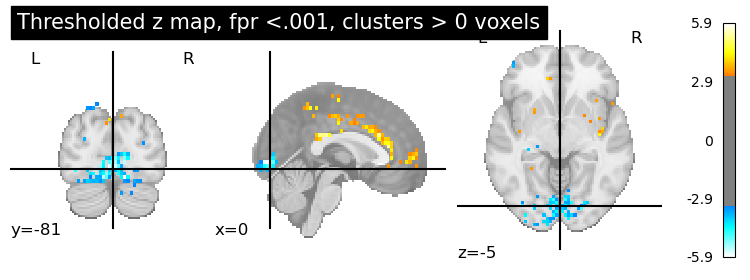

In [47]:
plotting.plot_stat_map(
    thresholded_map1_laypersons,
    threshold=threshold1_laypersons,
    title="Thresholded z map, fpr <.001, clusters > 0 voxels",
)

In [48]:
table1_laypersons = get_clusters_table(thresholded_map1_laypersons, stat_threshold=0, cluster_threshold=0)#TODO:此时的stat_threshold小于上面的阈值时都无效
table1_laypersons

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-6.5,-6.5,45.25,5.403949,67
1,2,-0.5,-27.5,26.50,5.361815,2126
2,2a,2.5,-39.5,22.75,5.221393,
3,2b,5.5,-18.5,30.25,5.043307,
4,2c,-3.5,-21.5,26.50,4.912221,
...,...,...,...,...,...,...
268,249,-0.5,44.5,0.25,3.301308,33
269,250,29.5,-0.5,-7.25,3.300340,33
270,251,59.5,-57.5,7.75,3.299171,33
271,252,-27.5,-27.5,-11.00,3.298860,33


In [49]:
thresholded_map2_laypersons, threshold2_laypersons = threshold_stats_img(
    z_maps_paired_laypersons, alpha=.05, height_control='fdr', cluster_threshold=0)
print(f"The FDR=.05 threshold is {threshold2_laypersons:.3g}")

The FDR=.05 threshold is 3.25


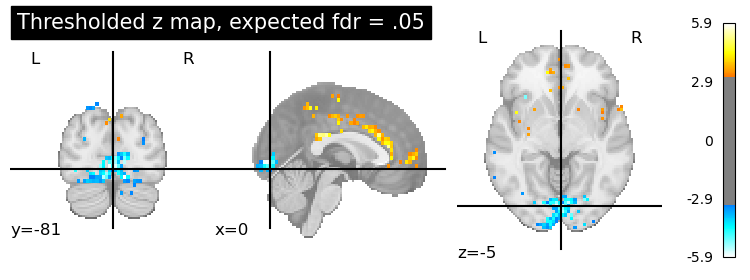

In [50]:
plotting.plot_stat_map(
    thresholded_map2_laypersons,
    title="Thresholded z map, expected fdr = .05",
    threshold=threshold2_laypersons,
)

In [51]:
table2_laypersons = get_clusters_table(thresholded_map2_laypersons, stat_threshold=0, cluster_threshold=0)#TODO:此时的stat_threshold小于上面的阈值时都无效
table2_laypersons

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-6.5,-6.5,45.25,5.403949,67
1,2,-0.5,-27.5,26.50,5.361815,2126
2,2a,2.5,-39.5,22.75,5.221393,
3,2b,5.5,-18.5,30.25,5.043307,
4,2c,-3.5,-21.5,26.50,4.912221,
...,...,...,...,...,...,...
272,253,-30.5,-0.5,-7.25,3.263120,33
273,254,5.5,50.5,-7.25,3.262959,33
274,255,-54.5,-30.5,34.00,3.260247,33
275,256,53.5,11.5,26.50,3.257854,33


In [52]:
thresholded_map3_laypersons, threshold3_laypersons = threshold_stats_img(
    z_maps_paired_laypersons, alpha=0.05, height_control="bonferroni"
)
print(f"The p<.05 Bonferroni-corrected threshold is {threshold3_laypersons:.3g}")

The p<.05 Bonferroni-corrected threshold is 4.94


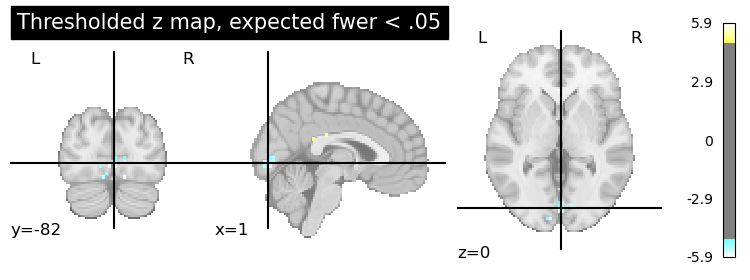

In [53]:
plotting.plot_stat_map(
    thresholded_map3_laypersons,
    title="Thresholded z map, expected fwer < .05",
    threshold=threshold3_laypersons,
)

In [54]:
table3_laypersons = get_clusters_table(thresholded_map3_laypersons, stat_threshold=0, cluster_threshold=0)#TODO:此时的stat_threshold小于上面的阈值时都无效
table3_laypersons

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-6.5,-6.5,45.25,5.403949,33
1,2,-0.5,-27.5,26.50,5.361815,135
2,3,-0.5,23.5,26.50,5.229011,33
3,4,2.5,-39.5,22.75,5.221393,33
4,5,-0.5,32.5,15.25,5.220221,33
5,6,14.5,-33.5,41.50,5.134546,33
6,7,5.5,-30.5,26.50,5.125597,33
7,8,5.5,-18.5,30.25,5.043307,67
8,9,38.5,2.5,11.50,5.022498,33
9,10,11.5,-72.5,34.00,4.989028,33


***********

# <center>2 法律职业人对道德判断问题和法律判断问题的差别——配对t检验</center>

### 2.1输入数据

In [57]:
outdir = 'results'
moral_z_maps_lawyer = sorted(glob(os.path.join(outdir, '*moral_zmap.nii.gz')))[n_subjects_laypersons:]
judge_z_maps_lawyer = sorted(glob(os.path.join(outdir, '*judge_zmap.nii.gz')))[n_subjects_laypersons:]
print(len(moral_z_maps_lawyer))
print(len(judge_z_maps_lawyer))
second_level_input_lawyer = moral_z_maps_lawyer + judge_z_maps_lawyer
second_level_input_lawyer

23
23


['results/sub-031-moral_zmap.nii.gz',
 'results/sub-032-moral_zmap.nii.gz',
 'results/sub-033-moral_zmap.nii.gz',
 'results/sub-034-moral_zmap.nii.gz',
 'results/sub-035-moral_zmap.nii.gz',
 'results/sub-036-moral_zmap.nii.gz',
 'results/sub-037-moral_zmap.nii.gz',
 'results/sub-038-moral_zmap.nii.gz',
 'results/sub-039-moral_zmap.nii.gz',
 'results/sub-040-moral_zmap.nii.gz',
 'results/sub-041-moral_zmap.nii.gz',
 'results/sub-042-moral_zmap.nii.gz',
 'results/sub-043-moral_zmap.nii.gz',
 'results/sub-044-moral_zmap.nii.gz',
 'results/sub-045-moral_zmap.nii.gz',
 'results/sub-046-moral_zmap.nii.gz',
 'results/sub-047-moral_zmap.nii.gz',
 'results/sub-048-moral_zmap.nii.gz',
 'results/sub-049-moral_zmap.nii.gz',
 'results/sub-050-moral_zmap.nii.gz',
 'results/sub-051-moral_zmap.nii.gz',
 'results/sub-052-moral_zmap.nii.gz',
 'results/sub-053-moral_zmap.nii.gz',
 'results/sub-031-judge_zmap.nii.gz',
 'results/sub-032-judge_zmap.nii.gz',
 'results/sub-033-judge_zmap.nii.gz',
 'results/su

### 2.2设计矩阵

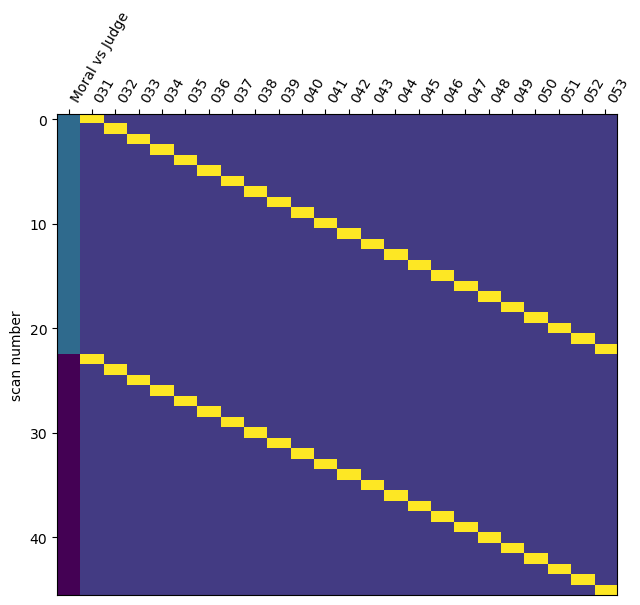

,Moral vs Judge,031,032,033,034,035,036,037,038,039,...,044,045,046,047,048,049,050,051,052,053
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
n_subjects_lawyer = len(subs) - n_subjects_laypersons # TODO：职业法律人共有23名
subject_effect_lawyer = np.vstack((np.eye(n_subjects_lawyer), np.eye(n_subjects_lawyer)))
condition_effect_lawyer = np.hstack(([1] * n_subjects_lawyer, [-1] * n_subjects_lawyer))

paired_design_matrix_lawyer = pd.DataFrame(
    np.hstack((condition_effect_lawyer[:, np.newaxis], subject_effect_lawyer)),
    columns=["Moral vs Judge"] + subs[n_subjects_laypersons:],
)
plot_design_matrix(paired_design_matrix_lawyer)
plt.show()
paired_design_matrix_lawyer

### 2.3二阶模型

In [59]:
second_level_model_paired_lawyer = SecondLevelModel(n_jobs=2).fit(
    second_level_input_lawyer, design_matrix=paired_design_matrix_lawyer
)

### 2.4计算统计量——无需指定对比矩阵，仅需指定单个参数

In [60]:
z_maps_paired_lawyer = second_level_model_paired_lawyer.compute_contrast("Moral vs Judge", output_type="z_score")

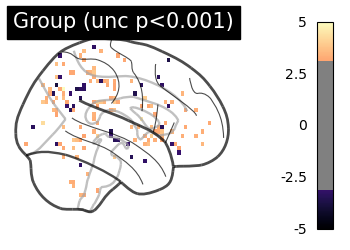

The unc threshold is 3.09


In [61]:
from scipy.stats import norm
p001_unc = norm.isf(0.001)

plotting.plot_glass_brain(z_maps_paired_lawyer, colorbar=True, threshold=p001_unc,
                          title='Group (unc p<0.001)',
                          plot_abs=False, display_mode='x', cmap='magma')
plotting.show()
print(f"The unc threshold is {p001_unc:.3g}")

### 2.5三种多重比较校正 & 打印坐标点

In [62]:
thresholded_map1_lawyer, threshold1_lawyer = threshold_stats_img(
    z_maps_paired_lawyer, alpha=0.001, height_control="fpr", cluster_threshold=0,
    two_sided=True,
)
print(f"The FPR<.001, clusters>0 voxels threshold is {threshold1_lawyer:.3g}")

The FPR<.001, clusters>0 voxels threshold is 3.29


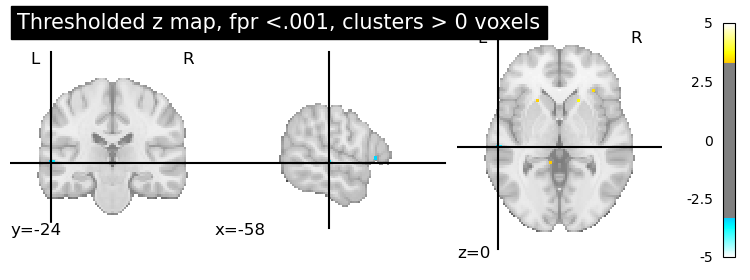

In [63]:
plotting.plot_stat_map(
    thresholded_map1_lawyer,
    threshold=threshold1_lawyer,
    title="Thresholded z map, fpr <.001, clusters > 0 voxels",
)

In [64]:
table1_lawyer = get_clusters_table(thresholded_map1_lawyer, stat_threshold=0, cluster_threshold=0)#TODO:此时的stat_threshold小于上面的阈值时都无效
table1_lawyer

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-15.5,-66.5,37.75,4.954384,33
1,2,-18.5,2.5,11.50,4.380441,33
2,3,-33.5,-84.5,7.75,4.247270,67
3,4,-3.5,-36.5,26.50,3.996312,33
4,5,17.5,-36.5,-3.50,3.960491,33
...,...,...,...,...,...,...
56,57,-0.5,50.5,19.00,3.322411,33
57,58,-21.5,38.5,-3.50,3.312563,33
58,59,-9.5,-39.5,0.25,3.304847,33
59,60,-21.5,14.5,-7.25,3.304764,33


In [65]:
thresholded_map2_lawyer, threshold2_lawyer = threshold_stats_img(
    z_maps_paired_lawyer, alpha=.05, height_control='fdr', cluster_threshold=0)
print(f"The FDR=.05 threshold is {threshold2_lawyer:.3g}")

The FDR=.05 threshold is 4.95


/home/hcp/anaconda3/envs/xj/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:143: UserWarning: Could not determine cut coords: All voxels were masked by the thresholding. Returning the center of mass instead.
  warnings.warn(
/home/hcp/anaconda3/envs/xj/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


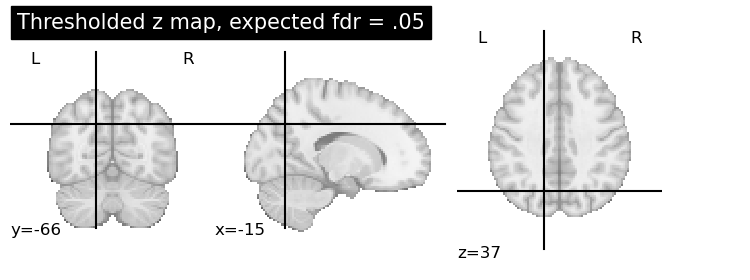

In [66]:
plotting.plot_stat_map(
    thresholded_map2_lawyer,
    title="Thresholded z map, expected fdr = .05",
    threshold=threshold2_lawyer,
)

In [67]:
table2_lawyer = get_clusters_table(thresholded_map2_lawyer, stat_threshold=0, cluster_threshold=0)#TODO:此时的stat_threshold小于上面的阈值时都无效
table2_lawyer

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-15.5,-66.5,37.75,4.954384,33


In [68]:
thresholded_map3_lawyer, threshold3_lawyer = threshold_stats_img(
    z_maps_paired_lawyer, alpha=0.05, height_control="bonferroni"
)
print(f"The p<.05 Bonferroni-corrected threshold is {threshold3_lawyer:.3g}")

The p<.05 Bonferroni-corrected threshold is 4.94


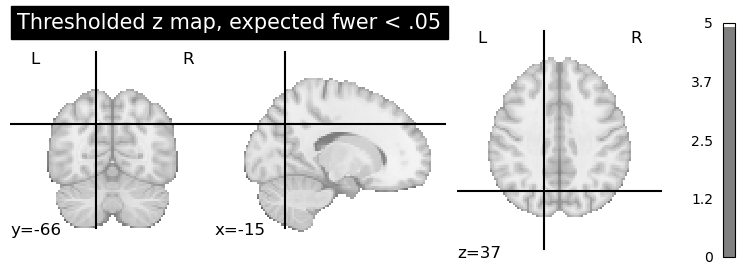

In [69]:
plotting.plot_stat_map(
    thresholded_map3_lawyer,
    title="Thresholded z map, expected fwer < .05",
    threshold=threshold3_lawyer,
)

In [70]:
table3_lawyer = get_clusters_table(thresholded_map3_lawyer, stat_threshold=0, cluster_threshold=0)#TODO:此时的stat_threshold小于上面的阈值时都无效
table3_lawyer

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-15.5,-66.5,37.75,4.954384,33


*************

# <center>3 法律教育是否会改变人对于道德问题与法律问题的判断——混合方差分析</center>

### 3.1输入数据

In [71]:
outdir = 'results'
list_z_maps = sorted(glob(os.path.join(outdir, '*.nii.gz')))
print(len(list_z_maps))
list_z_maps

144


['results/sub-001-common_sense_zmap.nii.gz',
 'results/sub-001-judge_zmap.nii.gz',
 'results/sub-001-moral_zmap.nii.gz',
 'results/sub-002-common_sense_zmap.nii.gz',
 'results/sub-002-judge_zmap.nii.gz',
 'results/sub-002-moral_zmap.nii.gz',
 'results/sub-003-common_sense_zmap.nii.gz',
 'results/sub-003-judge_zmap.nii.gz',
 'results/sub-003-moral_zmap.nii.gz',
 'results/sub-004-common_sense_zmap.nii.gz',
 'results/sub-004-judge_zmap.nii.gz',
 'results/sub-004-moral_zmap.nii.gz',
 'results/sub-005-common_sense_zmap.nii.gz',
 'results/sub-005-judge_zmap.nii.gz',
 'results/sub-005-moral_zmap.nii.gz',
 'results/sub-006-common_sense_zmap.nii.gz',
 'results/sub-006-judge_zmap.nii.gz',
 'results/sub-006-moral_zmap.nii.gz',
 'results/sub-007-common_sense_zmap.nii.gz',
 'results/sub-007-judge_zmap.nii.gz',
 'results/sub-007-moral_zmap.nii.gz',
 'results/sub-008-common_sense_zmap.nii.gz',
 'results/sub-008-judge_zmap.nii.gz',
 'results/sub-008-moral_zmap.nii.gz',
 'results/sub-009-common_sense_z

### 3.2设计矩阵

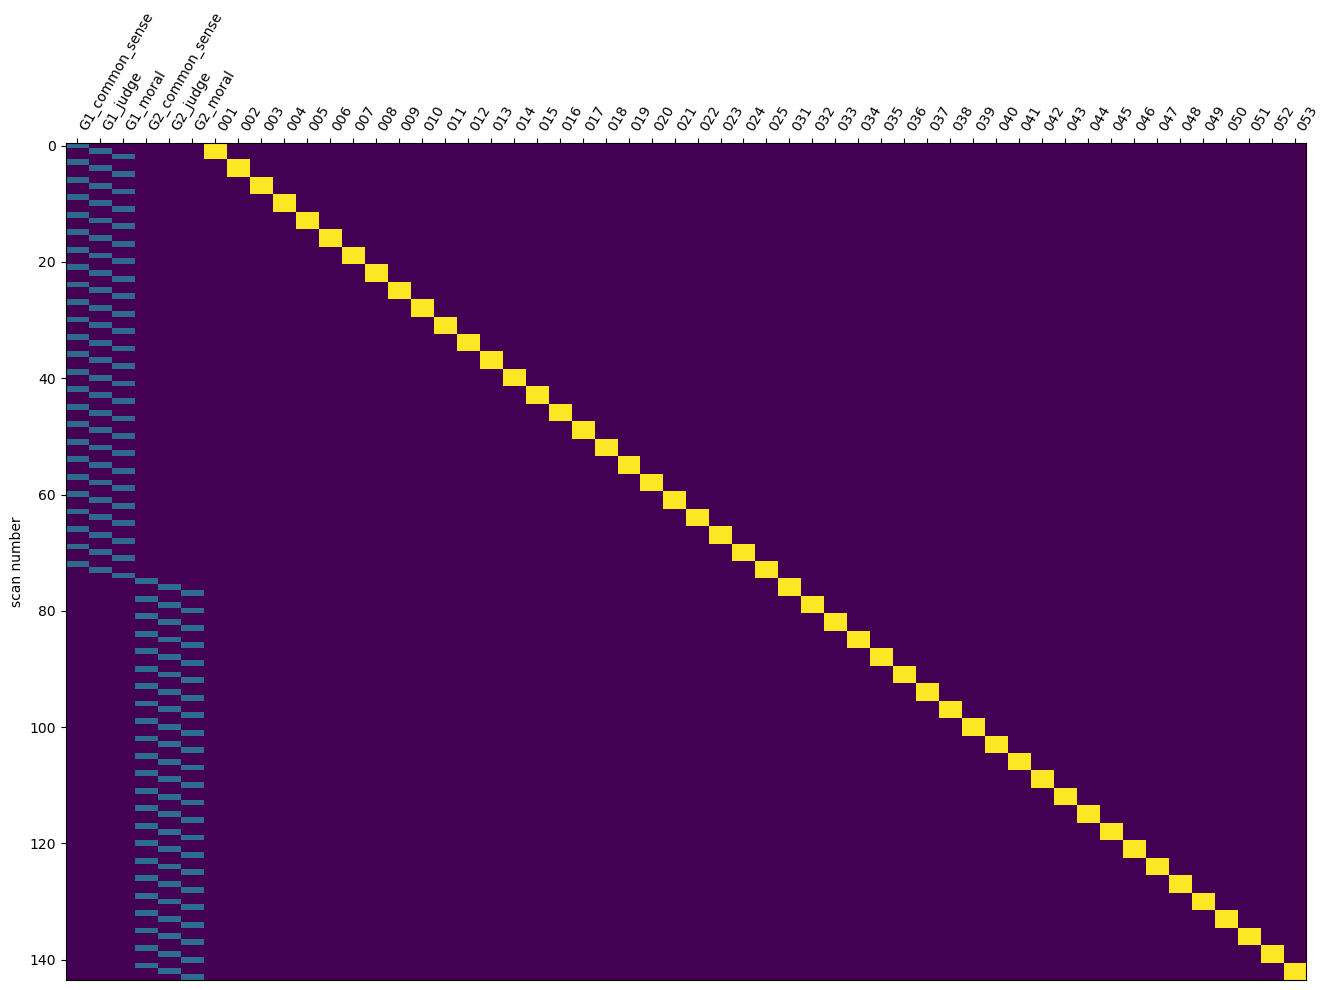

,G1_common_sense,G1_judge,G1_moral,G2_common_sense,G2_judge,G2_moral,001,002,003,004,...,044,045,046,047,048,049,050,051,052,053
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
140,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
141,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
142,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [72]:
n1 = np.tile(np.eye(3), (23, 1))
n0 = np.zeros(n1.shape)
X1 = np.concatenate((n1, n0), 1)
X2 = np.concatenate((n0, n1), 1)
#TODO：未接受法律教育者比接受过法律教育者多2名
n11 = np.tile(np.eye(3), (2, 1))
n00 = np.zeros(n11.shape)
X1_5 = np.concatenate((n11, n00), 1)
X = np.concatenate((X1, X1_5, X2), 0).astype(int)

# X = np.concatenate((X1, X2), 0).astype(int)
X_left = pd.DataFrame(X)
sub_id = []
for s in range(len(subs)):
    sub_id.extend([s]*3)
sub_means = pd.DataFrame([sub_id==x for x in np.unique(sub_id)]).T
X_right = sub_means.replace({True :1 ,False :0})
X = pd.concat([X_left, X_right], axis=1)
X.columns = ['G1_common_sense', 'G1_judge', 'G1_moral'] + ['G2_common_sense', 'G2_judge', 'G2_moral'] + subs
design_matrix = X
plot_design_matrix(design_matrix)
plt.show()
design_matrix

### 3.3二阶模型

In [73]:
second_level_model = SecondLevelModel(n_jobs=2).fit(list_z_maps, design_matrix=design_matrix)

### 3.4对比矩阵

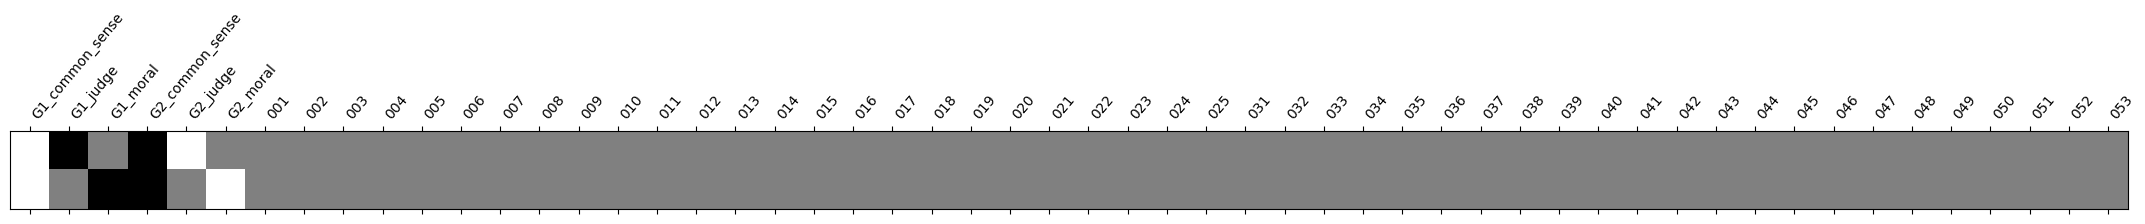

array([[ 1., -1.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 1.,  0., -1., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.]])

In [74]:
conditions = {"one": np.zeros(6 + len(subs)), "two": np.zeros(6 + len(subs))}
conditions['one'][0:5] = [1, -1, 0, -1, 1]
conditions['two'][0:6] = [1, 0, -1, -1, 0, 1]
contrast_matrix = np.vstack((conditions["one"], conditions["two"]))
plot_contrast_matrix(contrast_matrix, design_matrix)
plt.show()
contrast_matrix

### 3.5计算统计量——将对比矩阵传入

In [75]:
z_map_group = second_level_model.compute_contrast(contrast_matrix, output_type='z_score')

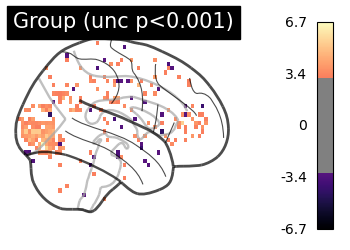

The unc threshold is 3.09


In [76]:
from scipy.stats import norm
p001_unc = norm.isf(0.001)

plotting.plot_glass_brain(z_map_group, colorbar=True, threshold=p001_unc,
                          title='Group (unc p<0.001)',
                          plot_abs=False, display_mode='x', cmap='magma')
plotting.show()
print(f"The unc threshold is {p001_unc:.3g}")

### 3.6三种多重比较校正 & 打印坐标点

In [77]:
thresholded_map1, threshold1 = threshold_stats_img(
    z_map_group, alpha=0.001, height_control="fpr", cluster_threshold=0,
    two_sided=True,
)
print(f"The FPR<.001, clusters>0 voxels threshold is {threshold1:.3g}")

The FPR<.001, clusters>0 voxels threshold is 3.29


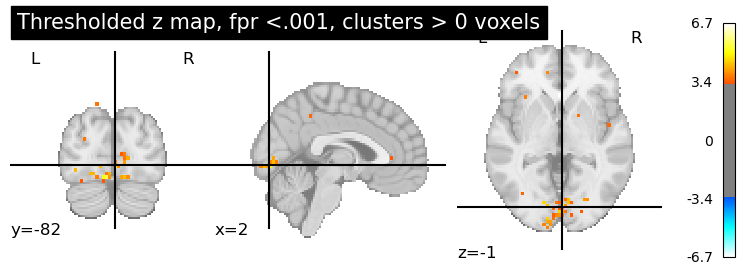

In [78]:
plotting.plot_stat_map(
    thresholded_map1,
    threshold=threshold1,
    title="Thresholded z map, fpr <.001, clusters > 0 voxels",
)

In [79]:
table1 = get_clusters_table(thresholded_map1, stat_threshold=0, cluster_threshold=0)#TODO:此时的stat_threshold小于上面的阈值时都无效
table1

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-3.5,-84.5,-11.00,6.719874,573
1,1a,-15.5,-78.5,-14.75,4.202911,
2,2,-12.5,38.5,7.75,5.307044,67
3,3,-0.5,-87.5,0.25,5.289582,1012
4,3a,5.5,-75.5,0.25,4.626271,
...,...,...,...,...,...,...
114,110,20.5,-87.5,-3.50,3.310248,33
115,111,-18.5,-33.5,19.00,3.304936,33
116,112,53.5,-21.5,30.25,3.301701,33
117,113,26.5,-75.5,-14.75,3.295501,33


In [80]:
thresholded_map2, threshold2 = threshold_stats_img(
    z_map_group, alpha=.05, height_control='fdr', cluster_threshold=0)
print(f"The FDR=.05 threshold is {threshold2:.3g}")

The FDR=.05 threshold is 4.19


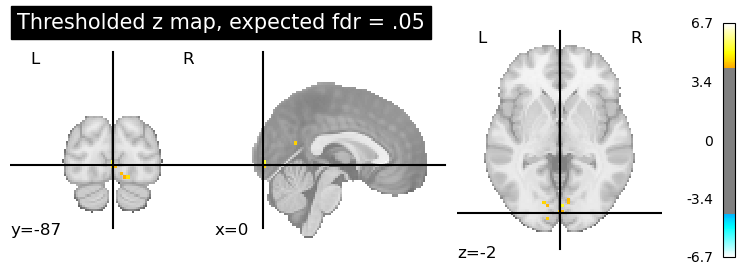

In [81]:
plotting.plot_stat_map(
    thresholded_map2,
    title="Thresholded z map, expected fdr = .05",
    threshold=threshold2,
)

In [82]:
table2 = get_clusters_table(thresholded_map2, stat_threshold=0, cluster_threshold=0)#TODO:此时的stat_threshold小于上面的阈值时都无效
table2

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-3.5,-84.5,-11.00,6.719874,67
1,2,-6.5,-81.5,-14.75,5.410806,67
2,3,-12.5,38.5,7.75,5.307044,33
3,4,-0.5,-87.5,0.25,5.289582,101
4,5,-15.5,-99.5,0.25,5.264311,33
5,6,-9.5,-93.5,0.25,5.261536,67
6,7,2.5,-81.5,-3.50,5.208727,33
7,8,-12.5,-96.5,-7.25,4.860920,33
8,9,59.5,-0.5,41.50,4.687991,33
9,10,14.5,-87.5,-14.75,4.687032,67


In [83]:
thresholded_map3, threshold3 = threshold_stats_img(
    z_map_group, alpha=0.05, height_control="bonferroni"
)
print(f"The p<.05 Bonferroni-corrected threshold is {threshold3:.3g}")

The p<.05 Bonferroni-corrected threshold is 4.94


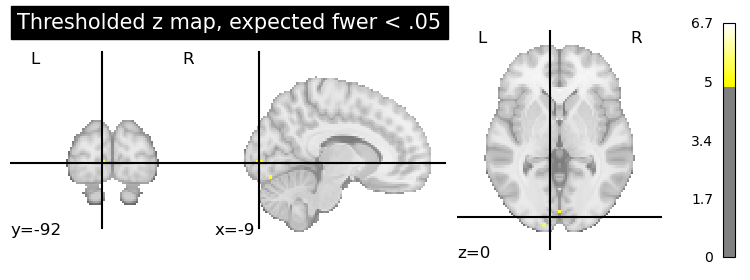

In [84]:
plotting.plot_stat_map(
    thresholded_map3,
    title="Thresholded z map, expected fwer < .05",
    threshold=threshold3,
)

In [85]:
table3 = get_clusters_table(thresholded_map3, stat_threshold=0, cluster_threshold=0)#TODO:此时的stat_threshold小于上面的阈值时都无效
table3

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-3.5,-84.5,-11.00,6.719874,33
1,2,-6.5,-81.5,-14.75,5.410806,67
2,3,-12.5,38.5,7.75,5.307044,33
3,4,-0.5,-87.5,0.25,5.289582,33
4,5,-15.5,-99.5,0.25,5.264311,33
5,6,-9.5,-93.5,0.25,5.261536,67
6,7,2.5,-81.5,-3.50,5.208727,33


**************

# <center>未完待续……</center>

### 1.还未进行数据质量验证，剔除不合格数据

### 2.一阶分析时，混合变量的选择还没有确定

### 3.组分析中的前两个配对t检验，应当可以在混合方差分析的设计矩阵基础之上，通过设计对比矩阵来实现。此处的配对t检验实现，模仿自nilearn的官网教程

### 4.组分析中，除了混合方差分析，前两个配对t检验没有用到common_sense